In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
%matplotlib inline

def input_missing_values(x_array):
    _x_array = deepcopy(x_array)
    size = len(_x_array)
    for i, x in enumerate(_x_array):
        for j, f_value in enumerate(x):
            if np.isnan(f_value):
                i_before = i
                i_after = i
                while np.isnan(_x_array[i_before, j]):
                    i_before -= 1
                    if i_before == -1:
                        break
                while np.isnan(_x_array[i_after, j]):
                    i_after += 1
                    if i_after == size:
                        break
                if i_before == -1 and i_after != size:
                    _x_array[i,j] = _x_array[i_after,j]
                elif i_before != -1 and i_after == size:
                    _x_array[i,j] = _x_array[i_before,j]
                elif i_before != -1:
                    _x_array[i,j] = (_x_array[i_before,j] + _x_array[i_after,j])/2
                else:
                    print("Nao ha valores para inputar na coluna de numero %d"%j)
                    return None
    return _x_array

def preprocess_data(data, columns="all", train_size=0.8):
    if columns != "all":
        data = data[columns+["total_cases"]]
    x = data.values[:,:-1]
    x = input_missing_values(x)
    y = data.values[:,-1]
    scaler = StandardScaler()
    x_std = scaler.fit_transform(x)
    train_size = int(train_size * len(x_std))
    x_train = x_std[:train_size,:]
    x_test = x_std[train_size:,:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    return x_train, x_test, y_train, y_test, scaler

def make_regression(regressor, x_train, x_test, y_train, y_test, name=""):
#     regressor.fit(x_train, y_train)

    y_pred = regressor.predict(x_train)

    plt.figure(figsize=(15,7))
    plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
    plt.plot([i for i in range(0,len(y_pred))], y_train, color="orange", label="Real")
    plt.legend()
    plt.title(name+" - Treino")
    plt.show()
    print("Mean absolute error: %f"%mean_absolute_error(y_train, y_pred))

    y_pred = regressor.predict(x_test)

    plt.figure(figsize=(15,7))
    plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
    plt.plot([i for i in range(0,len(y_pred))], y_test, color="orange", label="Real")
    plt.legend()
    plt.title(name+" - Teste")
    plt.show()
    print("Mean absolute error: %f"%mean_absolute_error(y_test, y_pred))

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

def find_best_params(model, param_grid, x, y):
    gscv = GridSearchCV(estimator=model, param_grid=param_grid,
                        scoring="neg_mean_absolute_error",
                        cv=10, n_jobs=-1)
    gscv.fit(x, y)
    return gscv.best_estimator_, gscv.cv_results_

In [12]:
x = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")
data = x.merge(y, on=("city", "year", "weekofyear")).sort_values(by=["year", "weekofyear"])
data_sj = data[data.city=="sj"]
data_sj = data_sj.drop(labels=["week_start_date","city"], axis=1)
data_iq = data[data.city=="iq"]
data_iq = data_iq.drop(labels=["week_start_date","city"], axis=1)

# data_sj.corr()["total_cases"].sort_values(ascending=False)

# cols = [
#         "reanalysis_specific_humidity_g_per_kg",
#         "reanalysis_dew_point_temp_k",
#         "station_max_temp_c",
#         "reanalysis_tdtr_k"
#        ]

x_sj, _, y_sj, _, _ = preprocess_data(data_sj, columns="all", train_size=1)
x_train_sj, x_test_sj, y_train_sj, y_test_sj, _ = preprocess_data(data_sj, columns="all", train_size=0.8)

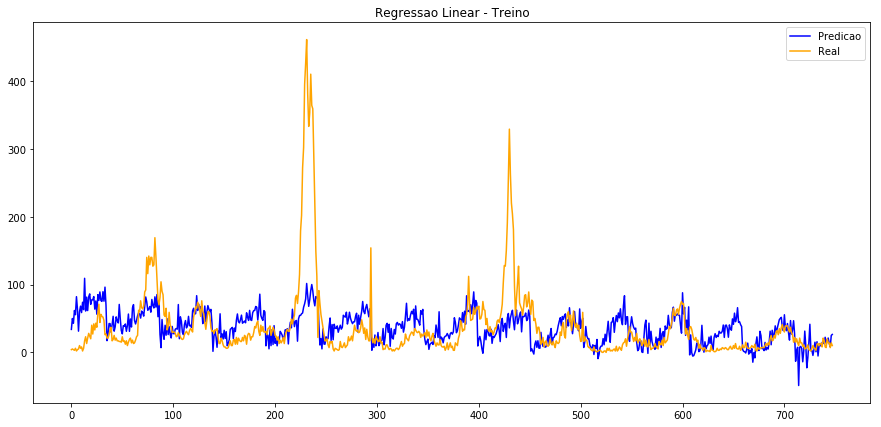

Mean absolute error: 28.006939


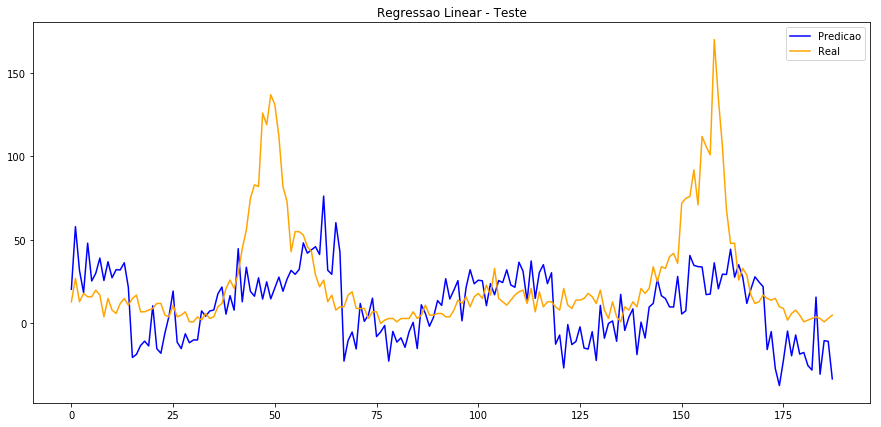

Mean absolute error: 23.349801


In [13]:
param_grid = {
    "normalize":[True,False],
    "fit_intercept":[True, False]
}

lr = LinearRegression()
lr, lr_res = find_best_params(lr, param_grid, x_train_sj, y_train_sj)

make_regression(lr, x_train_sj, x_test_sj, y_train_sj, y_test_sj, name="Regressao Linear")

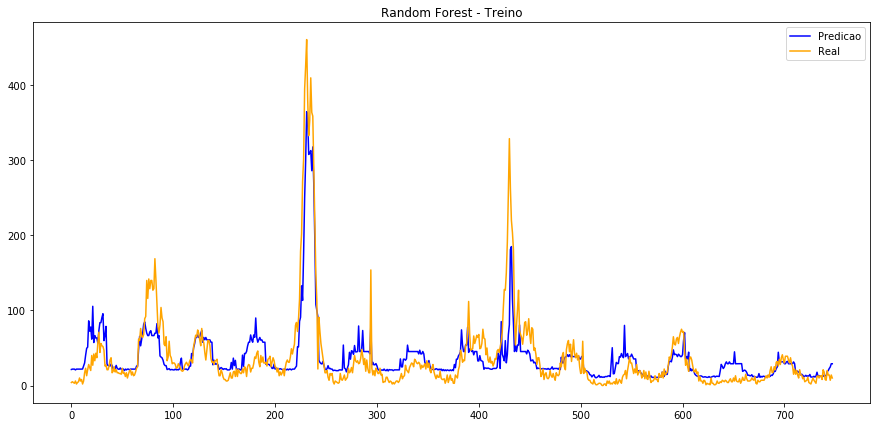

Mean absolute error: 17.402460


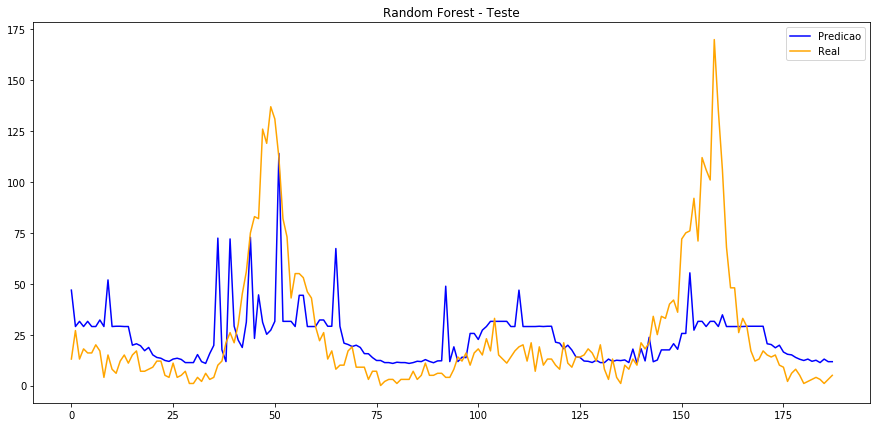

Mean absolute error: 17.443863


In [14]:
param_grid = {
    "max_depth":[n for n in range(1,20)],
    "max_features":[n for n in range(1,23)],
#     "n_estimators":[n for n in range(1,20)]
}

rfr = RandomForestRegressor(random_state=1)
rfr, rfr_res = find_best_params(rfr, param_grid, x_train_sj, y_train_sj)

make_regression(rfr, x_train_sj, x_test_sj, y_train_sj, y_test_sj, name="Random Forest")

In [16]:
from IPython.display import display

#ranking de melhores parametros
with pd.option_context("max_rows", None):
    display(pd.DataFrame(rfr_res).sort_values(by="mean_test_score"))

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
212,0.077253,0.001516,-35.315489,-8.185023,10,15,"{'max_depth': 10, 'max_features': 15}",418,-52.762350,-7.406395,...,-23.881456,-9.407172,-21.430760,-9.181720,-11.426314,-8.950707,0.001624,0.000123,18.508575,1.044954
235,0.086901,0.001578,-34.791645,-7.850258,11,16,"{'max_depth': 11, 'max_features': 16}",417,-60.022302,-7.995816,...,-23.624361,-8.902429,-24.339193,-9.062267,-9.829548,-8.557148,0.003083,0.000110,20.018777,0.931369
366,0.091947,0.001440,-34.563180,-7.174524,17,15,"{'max_depth': 17, 'max_features': 15}",416,-43.343333,-6.783611,...,-22.184947,-7.225680,-21.423588,-8.785855,-11.201351,-7.583621,0.005402,0.000153,18.189595,0.907198
169,0.074096,0.001541,-34.388378,-10.081426,8,16,"{'max_depth': 8, 'max_features': 16}",415,-49.870900,-10.374804,...,-22.195561,-10.891734,-22.678096,-12.029743,-9.619122,-11.914882,0.002810,0.000143,18.860723,1.468813
345,0.094406,0.001540,-34.383664,-7.082405,16,16,"{'max_depth': 16, 'max_features': 16}",414,-50.757333,-6.920793,...,-25.622086,-7.642351,-22.928659,-8.150589,-10.381081,-7.538559,0.003207,0.000092,19.212058,0.792616
367,0.093392,0.001503,-34.299420,-7.395667,17,16,"{'max_depth': 17, 'max_features': 16}",413,-51.584000,-7.295938,...,-22.519216,-7.583535,-21.950534,-8.805939,-9.947410,-8.635669,0.004718,0.000088,19.121846,0.958506
344,0.089953,0.001456,-34.220201,-7.136931,16,15,"{'max_depth': 16, 'max_features': 15}",412,-48.427707,-7.263816,...,-26.822533,-7.863171,-23.027374,-8.513622,-10.131757,-7.437269,0.004126,0.000047,18.269646,0.880575
389,0.094432,0.001919,-34.121908,-7.275481,18,16,"{'max_depth': 18, 'max_features': 16}",411,-51.653333,-7.202130,...,-25.106400,-7.463347,-24.968533,-8.258768,-9.744595,-7.951986,0.003476,0.001314,18.991868,0.787979
241,0.113052,0.001521,-33.951262,-7.372267,11,22,"{'max_depth': 11, 'max_features': 22}",410,-59.252113,-7.623187,...,-21.583998,-7.785972,-21.258846,-8.397191,-10.098006,-7.879122,0.005412,0.000066,19.809441,0.916891
256,0.085786,0.001519,-33.927426,-7.447380,12,15,"{'max_depth': 12, 'max_features': 15}",409,-54.403093,-7.905366,...,-23.234803,-7.604908,-20.411299,-8.625565,-9.599391,-7.799550,0.001970,0.000148,19.169234,0.776269


### Treinando com o dataset todo nas duas cidades

In [4]:
x = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")
data = x.merge(y, on=("city", "year", "weekofyear")).sort_values(by=["year", "weekofyear"])
data_sj = data[data.city=="sj"]
data_sj = data_sj.drop(labels=["week_start_date","city"], axis=1)
data_iq = data[data.city=="iq"]
data_iq = data_iq.drop(labels=["week_start_date","city"], axis=1)

x_sj, _, y_sj, _, scaler_sj = preprocess_data(data_sj, columns="all", train_size=1)
x_iq, _, y_iq, _, scaler_iq = preprocess_data(data_iq, columns="all", train_size=1)

rf_sj = RandomForestRegressor(max_depth=3, max_features=6)
rf_sj.fit(x_sj, y_sj)
rf_iq = RandomForestRegressor(max_depth=3, max_features=11)
rf_iq.fit(x_iq, y_iq)

##rode para achar os melhores parametros
# param_grid = {
#     "max_depth":[n for n in range(1,20)],
#     "max_features":[n for n in range(1,23)],
# }

# rf_sj, scores_sj = find_best_params(rf_sj, param_grid, x_sj, y_sj)
# rf_iq, scores_iq = find_best_params(rf_iq, param_grid, x_iq, y_iq)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=11, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [6]:
test_drivendata = pd.read_csv("data/dengue_features_test.csv")
test_drivendata_sj = test_drivendata[test_drivendata.city=="sj"]
test_drivendata_sj = test_drivendata_sj.drop(labels=["week_start_date","city"], axis=1)
x_test_sj = test_drivendata_sj.values
x_test_sj = input_missing_values(x_test_sj)
x_test_sj = scaler_sj.transform(x_test_sj)

test_drivendata_iq = test_drivendata[test_drivendata.city=="iq"]
test_drivendata_iq = test_drivendata_iq.drop(labels=["week_start_date","city"], axis=1)
x_test_iq = test_drivendata_iq.values
x_test_iq = input_missing_values(x_test_iq)
x_test_iq = scaler_iq.transform(x_test_iq)

In [27]:
y_pred_sj = rf_sj.predict(x_test_sj)
y_pred_sj = list(map(round, y_pred_sj))
y_pred_sj = list(map(int, y_pred_sj))

y_pred_iq = rf_iq.predict(x_test_iq)
y_pred_iq = list(map(round, y_pred_iq))
y_pred_iq = list(map(int, y_pred_iq))

### Salvando resultados para submissão (Random Forest Regression)

In [28]:
results_sj = test_drivendata_sj[["year","weekofyear"]]
results_sj["city"] = "sj"
results_sj["total_cases"] = y_pred_sj

results_iq = test_drivendata_iq[["year","weekofyear"]]
results_iq["city"] = "iq"
results_iq["total_cases"] = y_pred_iq

submission = pd.concat([results_sj, results_iq])
submission[["city","year","weekofyear","total_cases"]].to_csv("submission.csv", index=False)

/Users/carlos/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/carlos/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/carlos/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in